# The Naive Bayes Classifier

In this chapter, we introduce the naive Bayes classifier, which can be applied to data with categorical predictors. We review the concept of conditional probabilities, then present the complete, or exact, Bayesian classifier. We next see how it is impractical in most cases, and learn how to modify it and use instead the naive Bayes classifier,
which is more generally applicable.

## Imports

In this chapter, we will use `pandas` for data handling, `scikit-learn` for naive Bayes models, and `matplotlib` for visualization. We will also make use of the utility functions `dmutils`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from dmutils import classification_summary, gains_chart

## Introduction

The naive Bayes method (and, indeed, an entire branch of statistics) is named after the Reverend Thomas Bayes (1702–1761). To understand the naive Bayes classifier, we first look at the complete, or exact, Bayesian classifier. The basic principle is simple. For each record to be classified:

1. Find all the other records with the same predictor profile (i.e., where the predictor values are the same).
2. Determine what classes the records belong to and which class is most prevalent.
3. Assign that class to the new record.

Alternatively (or in addition), it may be desirable to tweak the method so that it answers the question: "What is the propensity of belonging to the class of interest?" instead of "Which class is the most probable?". Obtaining class probabilities allows using a sliding cutoff to classify a record as belonging to class $C_i$, even if $C_i$ is not the most probable class for that record. This approach is useful when there is a specific class of interest that we are interested in identifying, and we are willing to "overidentify" records as belonging to this class (see [Evaluating Predictive Performance](evaluating-predictive-performance.ipynb) for more details on the use of cutoffs for classification and on asymmetric misclassification costs).

### Cutoff Probability Method

1. Establish a cutoff probability for the class of interest above which we consider that a record belongs to that class.
2. Find all the training records with the same predictor profile as the new record (i.e., where the predictor values are the same).
3. Determine the probability that those records belong to the class of interest.
4. If that probability is above the cutoff probability, assign the new record to the class of interest.

### Conditional Probability

Both procedures incorporate the concept of *conditional probability*, or the probability of event *A* given that event *B* has occurred, denoted *P(A|B)*. In this case, we will be looking at the probability of the record belonging to class $C_i$ given that its predictor values are $x_1$, $x_2$, ..., $x_p$. In general, for a response with *m* classes $C_1$, $C_2$, ..., $C_m$, and the predictor values $x_1$, $x_2$, ..., $x_p$  we want to compute:

<p style="text-align:center">
    $P(C_i|x_i, ..., x_p)$
</p>
    
To classify a record, we compute its probability of belonging to each of the classes in this way, then classify the record to the class that has the highest probability or use the cutoff probability to decide whether it should be assigned to the class of interest.

From this definition, we see that the Bayesian classifier works only with categorical predictors. If we use a set of numerical predictors, then it is highly unlikely that multiple records will have identical values on these numerical predictors. Therefore, numerical predictors must be binned and converted to categorical predictors. *The Bayesian classifier is the only classification or prediction method presented in this book that is especially suited for (and limited to) categorical predictor variables.*

## Example 1: Predicting Fraudulent Financial Reporting

An accounting firm has many large companies as customers. Each customer submits an annual financial report to the firm, which is then audited by the accounting firm. For simplicity, we will designate the outcome of the audit as "fraudulent" or "truthful", referring to the accounting firm's assessment of the customer's financial report. The
accounting firm has a strong incentive to be accurate in identifying fraudulent reports - if it passes a fraudulent report as truthful, it would be in legal trouble.

The accounting firm notes that, in addition to all the financial records, it also has information on whether or not the customer has had prior legal trouble (criminal or civil charges of any nature filed against it). This information has not been used in previous audits, but the accounting firm is wondering whether it could be used in the future to identify reports that merit more intensive review. Specifically, it wants to know whether having had prior legal trouble is predictive of fraudulent reporting.

In this case, each customer is a record, and the outcome variable of interest, $Y = \{\text{fraudulent}, \text{truthful}\}$, has two classes into which a company can be classified: $C_1 = \text{fraudulent}$ and $C_2 = \text{truthful}$. The predictor variable - "prior legal trouble" - has two values: 0 (no prior legal trouble) and 1 (prior legal trouble).

The accounting firm has data on 1500 companies that it has investigated in the past. For each company, it has information on whether the financial report was judged fraudulent or truthful and whether the company had prior legal trouble. The data were partitioned into a training set (1000 firms) and a validation set (500 firms). Counts in the training set are shown in the table below:

|                   | Prior legal (X=1)| Prior legal (X=0)| Total | 
|:------------------|:-----------------|:-----------------|:------|
| Fraudulent ($C_1$)| 50               | 50               | 100   |
| Truthful   ($C_2$)| 180              | 720              | 900   |
| Total             | 230              | 770              | 1000  |

## Applying the Full (Exact) Bayesian Classifier

Now consider the financial report from a new company, which we wish to classify as either fraudulent or truthful by using these data. To do this, we compute the probabilities, as above, of belonging to each of the two classes.

If the new company had had prior legal trouble, the probability of belonging to the fraudulent class would be:

<p style="text-align:center">
    $P(\text{fraudulent} ∣ \text{prior legal}) = \frac{50}{230}$
</p>

of the 230 companies with prior legal trouble in the training set, 50 had fraudulent financial reports. The probability of belonging to the other class, "truthful", is of course, the remainder

<p style="text-align:center">
    $P(\text{truthful} ∣ \text{prior legal}) = \frac{180}{230}$
</p>

### Using the "Assign to the Most Probable Class" Method

If a company had prior legal trouble, we assign it to the "truthful" class. Similar calculations for the case of no prior legal trouble are computed the same way. In this example, using the rule "assign to the most probable class", all records are assigned to the "truthful" class. This is the same result as the naive rule of "assign all records to the majority class".

### Using Cutoff Probability Method

In this example, we are more interested in identifying the fraudulent reports - those are the ones that can land the auditor in jail. We recognize that, in order to identify the fraudulent reports, some truthful reports will be misidentified as fraudulent, and the overall classification accuracy may decline. Our approach is, therefore, to establish a cutoff value for the probability of being fraudulent, and classify all records above that value as fraudulent. The Bayesian formula for the calculation of this probability that a record belongs to class $C_i$ is as follows:

<p style="text-align:center">
    $P(C_i ∣ x_1, ..., x_p) = \frac{P(x_1, ..., x_p ∣ C_i) P(C_i)}{P(x_1, ..., x_p ∣ C_1) P(C_1) + ... + P(x_1, ..., x_p ∣ C_m) P(C_m)}$
</p>

In this example (where frauds are rarer), if the cutoff were established at 0.20, we would classify a prior legal trouble record as fraudulent because:

<p style="text-align:center">
    $P(\text{fraudulent} ∣ \text{prior legal}) = \frac{50}{230} = 0.22$
</p>
        
The user can treat this cutoff as a "slider" to be adjusted to optimize performance, like other parameters in any classification model.

### Practical Difficulty with the Complete (Exact) Bayes Procedure

The approach outlined above amounts to finding all the records in the sample that are exactly like the new record to be classified in the sense that all the predictor values are all identical. This was easy in the small example presented above, where there was just one predictor.

When the number of predictors gets larger (even to a modest number like 20), many of the records to be classified will be without exact matches. This can be understood in the context of a model to predict voting on the basis of demographic variables. Even a sizable sample may not contain even a single match for a new record who is a male Hispanic with high income from the US Midwest who voted in the last election, did not vote in the prior election, has three daughters and one son, and is divorced. And this is just eight variables, a small number for most data mining exercises. The addition of just a single new variable with five equally frequent categories reduces the probability of a match by a factor of 5.

### Solution: Naive Bayes

In the naive Bayes solution, we no longer restrict the probability calculation to those records that match the record to be classified. Instead we use the entire dataset.

Returning to our original basic classification procedure outlined at the beginning of the chapter, recall that the procedure for classifying a new record was:

1. Find all the other records with the same predictor profile (i.e., where the predictor values are the same).
2. Determine what classes the records belong to and which class is most prevalent.
3. Assign that class to the new record.

*The naive Bayes modification (for the basic classification procedure) is as follows:*

1. For class C 1 , estimate the individual conditional probabilities for each predictor $P(x_j | C_1)$ - these are the probabilities that the predictor value in the record to be classified occurs in class $C_1$. For example, for $X_1$ this probability is estimated by the proportion of $x_1$ values among the $C_1$ records in the training set.
2. Multiply these probabilities by each other, then by the proportion of records belonging to class $C_1$.
3. Repeat Steps 1 and 2 for all the classes.
4. Estimate a probability for class $C_i$ by taking the value calculated in Step 2 for class $C_i$ and dividing it by the sum of such values for all classes.
5. Assign the record to the class with the highest probability for this set of predictor values.

The above steps lead to the naive Bayes formula for calculating the probability that a record with a given set of predictor values $x_1$, ..., $x_p$ belongs to class $C_1$ among $m$ classes. The formula can be written as follows:

<p style="text-align:center">
    $P_{nb}(C_1 ∣ x_1, ..., x_p) = \frac{P(C_1)[P(x_1 ∣ C_1) P(x_2 ∣ C_1)...P(x_p ∣ C_1)]}{P(C_1)[P(x_1 ∣ C_1) P(x_2 ∣ C_1)...P(x_p ∣ C_1)] + ... + P(C_m)[P(x_1 ∣ C_m) P(x_2 ∣ C_m)...P(x_p ∣ C_m)]}$
</p>

This is a somewhat formidable formula; see Example 2 for a simpler numerical version. Note that all the needed quantities can be obtained from pivot tables of *Y* vs. each of the categorical predictors.

### The Naive Bayes Assumption of Conditional Independence

In probability terms, we have made a simplifying assumption that the exact *conditional probability* of seeing a record with predictor profile $x_1$, $x_2$, ..., $x_p$ within a certain class, 

<p style="text-align:center">
    $P(x_1, x_2, ..., x_p | C_i)$,
</p>

is well approximated by the product of the individual conditional probabilities

<p style="text-align:center">
    $P(x_1 | C_i ) × P(x_2 | C_i) × ... × P(x_p | C_i)$.
</p>

These two quantities are identical when the predictors are independent within each class.

For example, suppose that "lost money last year" is an additional variable in the accounting fraud example. The simplifying assumption we make with naive Bayes is that, within a given class, we no longer need to look for the records characterized both by "prior legal trouble" and "lost money last year". Rather, assuming that the two are
independent, we can simply multiply the probability of "prior legal trouble" by the probability of "lost money last year". Of course, complete independence is unlikely in practice, where some correlation between predictors is expected.

In practice, despite the assumption violation, the procedure works quite well - primarily because what is usually needed is not a propensity for each record that is accurate in absolute terms but just a reasonably accurate *rank ordering* of propensities. Even when the assumption is violated, the rank ordering of the records' propensities is typically preserved.

Note that if all we are interested in is a rank ordering, and the denominator remains the same for all classes, it is sufficient to concentrate only on the numerator. The disadvantage of this approach is that the probability values it yields (the propensities), while ordered correctly, are not on the same scale as the exact values that the user
would anticipate.

### Using the Cutoff Probability Method

The above procedure is for the basic case where we seek maximum classification accuracy for all classes. In the case of the *relatively rare class of special interest*, the procedure is:

1. Establish a cutoff probability for the class of interest above which we consider that a record belongs to that class.
2. For the class of interest, compute the probability that each individual predictor value in the record to be classified occurs in the training data.
3. Multiply these probabilities times each other, then times the proportion of records belonging to the class of interest.
4. Estimate the probability for the class of interest by taking the value calculated in Step 3 for the class of interest and dividing it by the sum of the similar values for all classes.
5. If this value falls above the cutoff, assign the new record to the class of interest, otherwise not.
6. Adjust the cutoff value as needed, as a parameter of the model

## Example 2: Predicting Fraudulent Financial Reports, Two Predictors

Let us expand the financial reports example to two predictors, and, using a small subset of data, compare the complete (exact) Bayes calculations to the naive Bayes calculations.

Consider the 10 customers of the accounting firm listed below. For each customer, we have information on whether it had prior legal trouble, whether it is a small or large company, and whether the financial report was found to be fraudulent or truthful. Using this information, we will calculate the conditional probability of fraud, given each of the four possible combinations $\{\text{y}, \text{small}\}$, $\{\text{y}, \text{large}\}$, $\{\text{n}, \text{small}\}$, $\{\text{n}, \text{large}\}$.

| Company           | Prior legal trouble| Company Size     | Status     | 
|:------------------|:-------------------|:-----------------|:-----------|
| 1                 | Yes                | Small            | Truthful   |
| 2                 | No                 | Small            | Truthful   |
| 3                 | No                 | Large            | Truthful   |
| 4                 | No                 | Large            | Truthful   |
| 5                 | No                 | Small            | Truthful   |
| 6                 | No                 | Small            | Truthful   |
| 7                 | Yes                | Small            | Fraudulent |
| 8                 | Yes                | Large            | Fraudulent |
| 9                 | No                 | Large            | Fraudulent |
| 10                | Yes                | Large            | Fraudulent |

**Complete (Exact) Bayes Calculations**

The probabilities are computed as:

<p style="text-align:center">
    <br>$P(\text{fraudulent} ∣ \text{Prior legal = y}, \text{Size = small}) = \frac{1}{2} = 0.5$
    <br>$P(\text{fraudulent} ∣ \text{Prior legal = y}, \text{Size = large}) = \frac{2}{2} = 1$
    <br>$P(\text{fraudulent} ∣ \text{Prior legal = n}, \text{Size = small}) = \frac{0}{3} = 0$
    <br>$P(\text{fraudulent} ∣ \text{Prior legal = n}, \text{Size = large}) = \frac{1}{3} = 0.33$
</p>

**Naive Bayes Calculations**

Now we compute the naive Bayes probabilities. For the conditional probability of fraudulent behaviors given $\{\text{prior legal = y}, \text{Size = small}\}$ the numerator is a multiplication of the proportion of $\{\text{Prior legal = y}\}$ instances among the fraudulent companies, times the proportion of $\{\text{Size = small}\}$ instances among the fraudulent companies, times the proportion of fraudulent companies:

<p style="text-align:center">
    $\frac{3}{4} \times \frac{1}{4} \times \frac{4}{10} = 0.075$
</p>

To get the actual probabilities, we must also compute the numerator for the conditional probability of truthful behaviors given $\{\text{Prior Legal = y}, \text{Size = small}\}$:

<p style="text-align:center">
    $\frac{1}{6} \times \frac{4}{6} \times \frac{6}{10} = 0.067$
</p>

The denominator is then the sum of these two conditional probabilities:

<p style="text-align:center">
    $ 0.075 + 0.067 = 0.14$
</p>

The conditional probability of fraudulent behaviors given $\{\text{Prior legal = y}, \text{Size = small}\}$ is therefore:

<p style="text-align:center">
    $\frac{0.075}{0.14} = 0.53$
</p>

In a similar fashion, we compute all four conditional probabilities:

<p style="text-align:center">
    <br>$P_{nb}(\text{fraudulent} ∣ \text{Prior legal = y}, \text{Size = small}) = \frac{(\frac{3}{4})(\frac{1}{4})(\frac{6}{10})}{(\frac{3}{4})(\frac{1}{4})(\frac{3}{4}) + (\frac{1}{6})(\frac{4}{6})(\frac{6}{10})} = 0.53$
    <br>$P_{nb}(\text{fraudulent} ∣ \text{Prior legal = y}, \text{Size = large}) = 0.87$
    <br>$P_{nb}(\text{fraudulent} ∣ \text{Prior legal = n}, \text{Size = small}) = 0.07$
    <br>$P_{nb}(\text{fraudulent} ∣ \text{Prior legal = n}, \text{Size = large}) = 0.31$
</p>

Note how close these naive Bayes probabilities are to the exact Bayes probabilities. Although they are not equal, both would lead to exactly the same classification for a cutoff of 0.5 (and many other values). It is often the case that the rank ordering of probabilities is even closer to the exact Bayes method than the probabilities themselves, and for classification purposes it is the rank orderings that matter.

We now consider a larger numerical example, where information on flights is used to predict flight delays.

## Example 3: Predicting Delayed Flights

Predicting flight delays can be useful to a variety of organizations: airport authorities, airlines, and aviation authorities. At times, joint task forces have been formed to address the problem. If such an organization were to provide ongoing real-time assistance with flight delays, it would benefit from some advance notice about flights that are likely to be delayed.

In this simplified illustration, we look at five predictors (see below). The outcome of interest is whether or not the flight is delayed (*delayed* here means arrived more than 15 minutes late). Our data consist of all flights from the Washington, DC area into the New York City area during January 2004. A record is a particular flight. The percentage of delayed flights among these 2201 flights is 19.5%. The data were obtained from the Bureau of Transportation Statistics (available at www.transtats.bts.gov). The goal is to accurately predict whether or not a new flight (not in this dataset), will be delayed. The outcome variable is whether the flight was delayed or not (1 = delayed and 0 = on time). In addition, information is collected on the predictors listed next:

    Day of week: Coded as 1 = Monday, 2 = Tuesday, ..., 7 = Sunday
    Sch. dep. time: Broken down into 18 intervals between 6:00 AM and 10:00 PM 
    Origin: Three airport codes: DCA (Reagan National), IAD (Dulles), BWI (Baltimore–Washington Int'l)
    Destination: Three airport codes: JFK (Kennedy), LGA (LaGuardia), EWR (Newark)
    Carrier: Eight airline codes: CO (Continental), DH (Atlantic Coast), DL (Delta),
             MQ (American Eagle), OH (Comair), RU (Continental Express), UA (United), and US (USAirways)

After converting all predictors to categorical and creating dummies, the data were partitioned into training (60%) and validation (40%) sets, and then a naive Bayes classifier was applied to the training set:

In [2]:
delays_df = pd.read_csv("../datasets/FlightDelays.csv")

# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype("category")
delays_df["Flight Status"] = delays_df["Flight Status"].astype("category")

# create hourly bins departure
delays_df.CRS_DEP_TIME = [round(t/100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype("category")

predictors = ["DAY_WEEK", "CRS_DEP_TIME", "ORIGIN", "DEST", "CARRIER"]
outcome = "Flight Status"

X = pd.get_dummies(delays_df[predictors])
y = delays_df["Flight Status"].astype("category")
classes = list(y.cat.categories)

# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)

# run naive Bayes
delays_nb = MultinomialNB(alpha=0.01)
delays_nb.fit(X_train, y_train)

# predict probabilities
pred_proba_train = delays_nb.predict_proba(X_train)
pred_proba_valid = delays_nb.predict_proba(X_valid)

# predict class membership
y_train_pred = delays_nb.predict(X_train)
y_valid_pred = delays_nb.predict(X_valid)

Before using the output, let's see how the algorithm works. We start by generating pivot tables for the outcome vs. each of the five predictors using the training set, in order to obtain conditional probabilities (table below). Note that in this example, there are no  predictor values that were not represented in the training data.

In [3]:
# split the original data frame into a train and test using the same
# random_state
train_df, valid_df = train_test_split(delays_df, test_size=0.40, random_state=1)

pd.set_option("precision", 4)
# probability of flight status
print(train_df["Flight Status"].value_counts() / len(train_df))
print()

for predictor in predictors:
    # construct the frequency table
    df = train_df[["Flight Status", predictor]]
    freq_table = df.pivot_table(index="Flight Status", columns=predictor, aggfunc=len)

    # divide each value by the sum of the row to get conditional probabilities
    prop_table = freq_table.apply(lambda x: x/sum(x), axis=1)
    print(prop_table)
    print()

pd.reset_option("precision")

ontime     0.8023
delayed    0.1977
Name: Flight Status, dtype: float64

DAY_WEEK            1       2       3       4       5      6       7
Flight Status                                                       
delayed        0.1916  0.1494  0.1149  0.1264  0.1877  0.069  0.1609
ontime         0.1246  0.1416  0.1445  0.1794  0.1690  0.136  0.1048

CRS_DEP_TIME        6       7       8       9      10      11      12      13  \
Flight Status                                                                   
delayed        0.0345  0.0536  0.0651  0.0192  0.0307  0.0115  0.0498  0.0460   
ontime         0.0623  0.0633  0.0850  0.0567  0.0519  0.0340  0.0661  0.0746   

CRS_DEP_TIME       14      15      16      17      18      19      20      21  
Flight Status                                                                  
delayed        0.0383  0.2031  0.0728  0.1533  0.0192  0.0996  0.0153  0.0881  
ontime         0.0576  0.1171  0.0774  0.1001  0.0349  0.0397  0.0264  0.0529  

ORIG

To classify a new flight, we compute the probability that it will be delayed and the probability that it will be on time. Recall that since both probabilities will have the same denominator, we can just compare the numerators. Each numerator is computed by multiplying all the conditional probabilities of the relevant predictor values and, finally, multiplying by the proportion of that class (in this case $\hat{P}$(delayed) = 0.2). Let us use an example: to classify a Delta flight from DCA to LGA departing between 10:00 AM and 11:00 AM on a Sunday, we first compute the numerators using the values from the pivot tables:

<p style="text-align:center">
    $\hat{P}(\text{delayed} ∣ \text{Carrier=DL}, \text{Day_Week}=7, \text{Dep_Time}=10, \text{Dest=LGA}, \text{Origin=DCA}) = \propto (0.2)(0.0958)(0.1609)(0.4215)(0.0307)(0.5211) = 0.000021$
    <br>$\hat{P}(\text{ontime} ∣ \text{Carrier=DL}, \text{Day_Week}=7, \text{Dep_Time}=10, \text{Dest=LGA}, \text{Origin=DCA}) = \propto (0.8)(0.2040)(0.1048)(0.05779)(0.0519)(0.6478) = 0.000033$
</p>

The symbol $\propto$ means "is proportional to", reflecting the fact that this calculation deals only with the numerator in the naive Bayes formula. Comparing the numerators, it is therefore, more likely that the flight will be on time. Note that a record with such a combination of predictor values does not exist in the training set, and therefore we use the naive Bayes rather than the exact Bayes. To compute the actual probability, we divide each of the numerators by their sum:

<p style="text-align:center">
    $\hat{P}(\text{delayed} ∣ \text{Carrier=DL}, \text{Day_Week}=7, \text{Dep_Time}=10, \text{Dest=LGA}, \text{Origin=DCA}) = \frac{0.000021}{0.000021+0.000033} = 0.058$,
    <br>$\hat{P}(\text{ontime} ∣ \text{Carrier=DL}, \text{Day_Week}=7, \text{Dep_Time}=10, \text{Dest=LGA}, \text{Origin=DCA}) = \frac{0.000033}{0.000021+0.000033} = 0.942$
</p>

Of course, we rely on software to compute these probabilities for any records of interest (in the training set, the validation set, or for scoring new data). The following table shows the predicted probability and class for the example flight, which coincide with our manual calculation.

In [4]:
# classify a specifi flight by searching in the dataset
# for a flight with the same predictor values
df = pd.concat([pd.DataFrame({"actual": y_valid, "predicted": y_valid_pred}),
                pd.DataFrame(pred_proba_valid, index=y_valid.index)], axis=1)

mask = ((X_valid.CARRIER_DL == 1) & (X_valid.DAY_WEEK_7 == 1) &
        (X_valid.CRS_DEP_TIME_10 == 1) & (X_valid.DEST_LGA == 1) &
        (X_valid.ORIGIN_DCA == 1))
df[mask]

,actual,predicted,0,1
1225,ontime,ontime,0.057989,0.942011


Finally, to evaluate the performance of the naive Bayes classifier for our data, we can use the confusion matrix, gains and lift charts, and all the measures that were described in [Evaluating Predictive Performance](evaluating-predictive-performance.ipynb). For our example, the confusion matrices for the training and validation sets are shown below. We see that the overall accuracy level is around 80% for both the training and validation data. In comparison, a naive rule that would classify all 880 flights in the validation set as "on time" would have missed the 172 delayed flights, also resulting in a 80% accuracy. Thus, by a simple accuracy measure, the naive Bayes model does no better than the naive rule.

In [5]:
# training
classification_summary(y_train, y_train_pred, class_names=classes)
print()

# validation
classification_summary(y_valid, y_valid_pred, class_names=classes)

Confusion Matrix (Accuracy 0.7955)

        Prediction
 Actual delayed  ontime
delayed      52     209
 ontime      61     998

Confusion Matrix (Accuracy 0.7821)

        Prediction
 Actual delayed  ontime
delayed      26     141
 ontime      51     663


However, examining the gains and lift charts shows the strength of the naive Bayes in capturing the delayed flights effectively, when the goal is ranking.

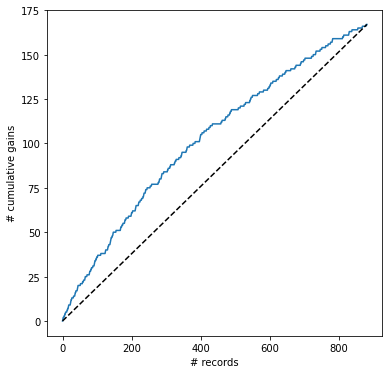

In [6]:
df = pd.DataFrame({"actual": 1 - y_valid.cat.codes, "prob": pred_proba_valid[:, 0]})
df = df.sort_values(by=["prob"], ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(6, 6))
gains_chart(df.actual, ax=ax)
plt.show()